In [37]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
from keras_tqdm import TQDMNotebookCallback
import random

In [18]:
import numpy as np
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file,
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

import os
def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [19]:
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [20]:
dog_image_id = os.listdir('images/dog')[0]
dog_image = load_image(os.path.join('images/dog',dog_image_id))
print(f'shape: {dog_image.shape}')
print(f'type: {type(dog_image)}')
model.predict(dog_image)

shape: (1, 224, 224, 3)
type: <class 'numpy.ndarray'>


array([[1.21624733e-09, 5.47697212e-08, 8.49026821e-11, 1.48057729e-11,
        9.58150004e-09, 4.14600123e-08, 1.54584345e-09, 7.80965763e-08,
        5.03861202e-08, 1.19961763e-09, 1.63343373e-07, 1.50555195e-07,
        3.54716745e-09, 3.30286483e-08, 3.59721808e-09, 1.05364943e-08,
        2.80557106e-08, 2.61460355e-06, 2.57961421e-08, 1.05282645e-07,
        8.17245116e-09, 1.35832190e-08, 9.74683043e-11, 7.83950611e-08,
        7.13448074e-08, 1.46383194e-09, 1.28130297e-08, 2.36927256e-09,
        3.11499782e-09, 1.52264390e-09, 9.14755827e-10, 2.54922536e-08,
        2.77623879e-09, 1.38742280e-07, 4.46373321e-08, 1.76074852e-08,
        6.40578222e-08, 2.40623130e-08, 5.69349634e-09, 1.10138814e-08,
        7.12805726e-09, 1.20233050e-08, 1.59847091e-09, 8.57058691e-09,
        2.28105007e-10, 5.48887613e-07, 2.06738484e-08, 3.43225537e-08,
        1.25856459e-07, 6.55691751e-11, 1.04688355e-10, 3.91172073e-09,
        6.85693413e-09, 6.82978119e-10, 2.16444751e-09, 1.108610

In [21]:
model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3),
  include_top=False,
  pooling='avg'
)

In [22]:
dog_image_id = os.listdir('images/dog')[0]
dog_image = load_image(os.path.join('images/dog',dog_image_id))
model.predict(dog_image).shape

(1, 1024)

In [23]:
x = Dropout(rate=0.4)(model.output)
# This determines the number of outputs, and thus the number of categories, in my test case 2: dog or cat
x = Dense(2)(x)
x = Softmax()(x)
model= Model(model.inputs, x)

In [24]:
for layer in model.layers[:-3]:
    layer.trainable = False

In [25]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy'
)

In [26]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=_mobilenet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

ensure_folder_exists('training_aug')
training = datagen.flow_from_directory(
    './images',
    target_size=(224, 224),
    save_to_dir='./training_aug',
    subset='training'
)

ensure_folder_exists('validation_aug')
validation = datagen.flow_from_directory(
    './images',
    target_size=(224, 224),
    save_to_dir='./validation_aug',
    subset='validation'
)

Found 364 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [27]:
batch_size = 32

history = model.fit(
    x=training,
    steps_per_epoch=training.samples // batch_size,
    epochs=10,
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

Epoch 1/10
11/11 [==============================] - 26s 2s/step - loss: 0.8493 - val_loss: 0.4249
Epoch 2/10
11/11 [==============================] - 18s 2s/step - loss: 0.4051 - val_loss: 0.2377
Epoch 3/10
11/11 [==============================] - 18s 2s/step - loss: 0.2941 - val_loss: 0.1474
Epoch 4/10
11/11 [==============================] - 19s 2s/step - loss: 0.2070 - val_loss: 0.1306
Epoch 5/10
11/11 [==============================] - 18s 2s/step - loss: 0.1641 - val_loss: 0.1040
Epoch 6/10
11/11 [==============================] - 18s 2s/step - loss: 0.1207 - val_loss: 0.0714
Epoch 7/10
11/11 [==============================] - 17s 2s/step - loss: 0.1245 - val_loss: 0.0549
Epoch 8/10
11/11 [==============================] - 18s 2s/step - loss: 0.0802 - val_loss: 0.0673
Epoch 9/10
11/11 [==============================] - 18s 2s/step - loss: 0.0782 - val_loss: 0.0687
Epoch 10/10
11/11 [==============================] - 18s 2s/step - loss: 0.0817 - val_loss: 0.0429


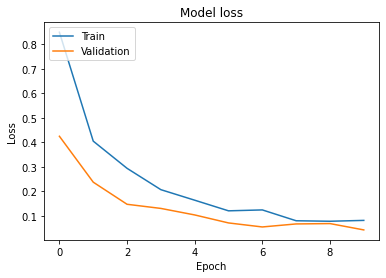

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [29]:
random_cat = random.choice(os.listdir('images/cat/'))
cat_path = os.path.join('images/cat',random_cat)
cat = load_image(cat_path)
random_dog = random.choice(os.listdir('images/dog/'))
dog_path = os.path.join('images/dog',random_dog)
dog = load_image(dog_path)

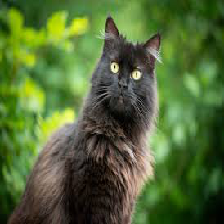

In [30]:
tf.keras.preprocessing.image.load_img(cat_path, target_size=(224,224))

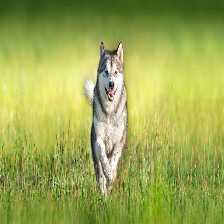

In [31]:
tf.keras.preprocessing.image.load_img(dog_path, target_size=(224,224))

In [32]:
print(f'''cat:{np.round(model.predict(cat),2)}''')

cat:[[0.99 0.01]]


In [33]:
print(f'''dog:{np.round(model.predict(dog),2)}''')

dog:[[0.06 0.94]]


In [34]:
elon_path = 'elon_with_disguise.jpg'
elon = load_image(elon_path)

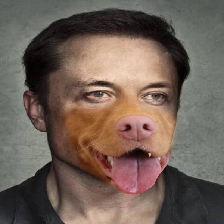

In [35]:
tf.keras.preprocessing.image.load_img(elon_path, target_size=(224,224))

In [36]:
print(f'''elon:{np.round(model.predict(elon),2)}''')

elon:[[0.52 0.48]]
